# Differential abundance analysis

Author: **Anna Toidze**

In this notebook, we will explore how to test whether specific ASVs (amplicon sequence variants) or taxa show differences in abundance between groups of samples—a type of analysis known as _differential abundance_.

Analyzing microbiome data presents two key challenges:
- Sparsity: The data contains many zero-values.
- Compositionality: The values are relative and sum to 1.

These challenges make traditional statistical methods (such as ANOVA or t-tests) unsuitable for differential abundance testing. Instead, we can use ANCOM-BC (Analysis of Composition of Microbiomes with Bias Correction), a compositionally aware method designed to identify differentially abundant features.

**Exercise overview:**

[0. Setup](#setup)<br>
[1. Data exploration](#data-exploration)<br>
[2. ANCOM](#ancom)<br>
[3. Checkpoint](#checkpoint)

<a id='setup'></a>

## 1. Setup

The cell below will import all the packages required in the downstream analyses as well as set all the necessary variables and data paths.

In [1]:
import os
import matplotlib.pyplot as plt
import pandas as pd
import qiime2 as q2
from qiime2 import Visualization
import seaborn as sns
from scipy.stats import shapiro, kruskal, f_oneway
import subprocess
from q2_composition import DataLoafPackageDirFmt

%matplotlib inline

In [2]:
# assigning variables throughout the notebook

# location of this week's data and all the results produced by this notebook
# - this should be a path relative to your working directory
raw_data_dir = "../data/raw"
data_dir = "../data/processed"
vis_dir  = "../results"

In [3]:
# setting seaborn formatting style
sns.set_style("white")
sns.set_theme(style="ticks", palette="pastel")

<a id='data-exploration'></a>
## 1. Data exploration

Microbiome data poses challenges for traditional statistical methods due to its sparsity (many zero-values) and non-normal distribution. To better understand these limitations, we'll visualize the data using a violin plot—a blend of a histogram and a box plot—that shows the full distribution along with summary statistics.

In [4]:
data = q2.Artifact.load(f'{data_dir}/table.qza').view(pd.DataFrame)

We show that the features are not normally distributed!

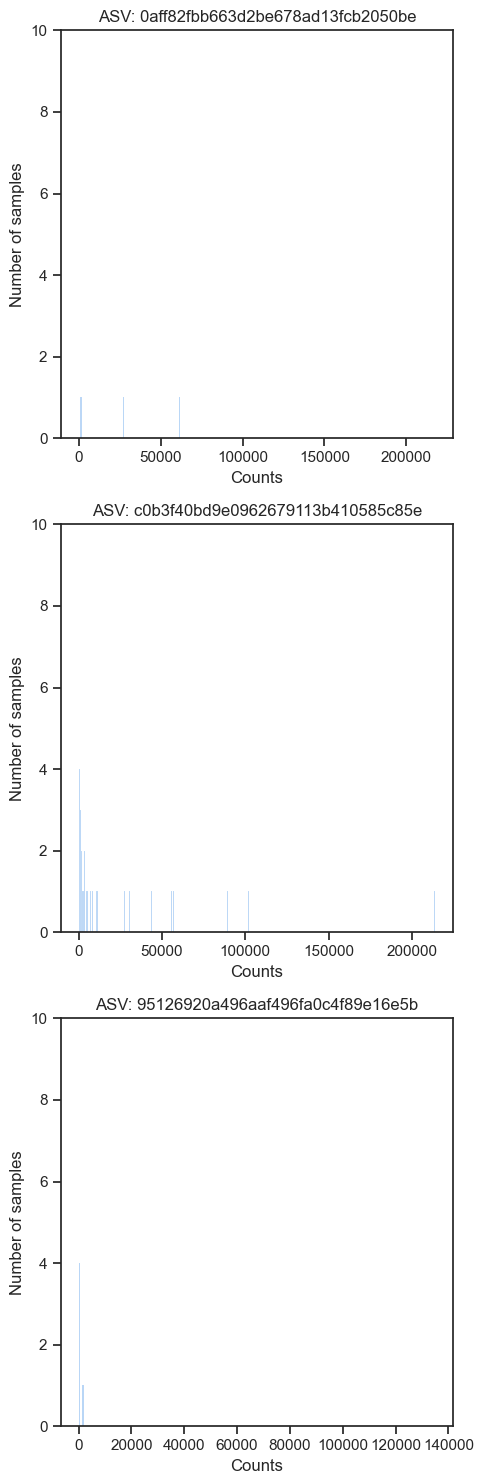

In [5]:
# Get the top three most abundant sequence variants
# based on sum of observed sequence counts. Create a dataframe of ASV counts 
# with samples as rows and sequence variants as columns.
top_three = data[data.sum(axis=0).sort_values(ascending=False).head(n=3).index]

top_three
# Your turn to try! Now view each of them as a histogram, as number of samples per ASV.
fig, axes = plt.subplots(3, 1, figsize=(5, 15))

for i, asv in enumerate(top_three):
    ax = axes.flatten()[i]
    sns.histplot(top_three, x=top_three[asv], ax=ax)
    ax.set_xlabel("Counts")
    ax.set_ylabel("Number of samples")
    ax.set_title(f"ASV: {asv}")
    ax.set_ylim(0,10)
    
    
    
plt.tight_layout()
plt.show()


To create a violin plot, we need to restructure the data into a new DataFrame with three columns: sample name, ASV ID, and ASV abundance. To simplify the visualization, we'll use only 15 samples from the original dataset.

In [6]:
n = 15

# draw n ASVs out of the original DataFrame
data_samp = data.sample(n=n, axis=1, random_state=23)

# create a new DataFrame with three columns (sample, ASV, abundance)
col_names = {'level_0': 'sample', 'level_1': 'asv', 0: 'count'}
data_plot = data_samp.stack().reset_index().rename(columns=col_names)

# make sure the shape is correct (no. of rows should be equal to the size of our random 
# sample multiplied by number of samples)
assert data_plot.shape[0] == n * data_samp.shape[0], 'The new DataFrame has an incorrect no. of rows.'

In [7]:
data_plot.head()

,sample,asv,count
0,EG0024,ead3a6d4c6481164ab627c229bab6f21,0.0
1,EG0024,81fe043da496de58da2066d994d5f979,0.0
2,EG0024,caf3dff992adc7810805466d1f5d21d9,0.0
3,EG0024,8fa5c543f4365d27e41836b099af98bf,0.0
4,EG0024,7e4730fdfcd01a668dca80d4168c1029,0.0


Now, let's plot distributions of our ASVs using seaborn's violin plot:

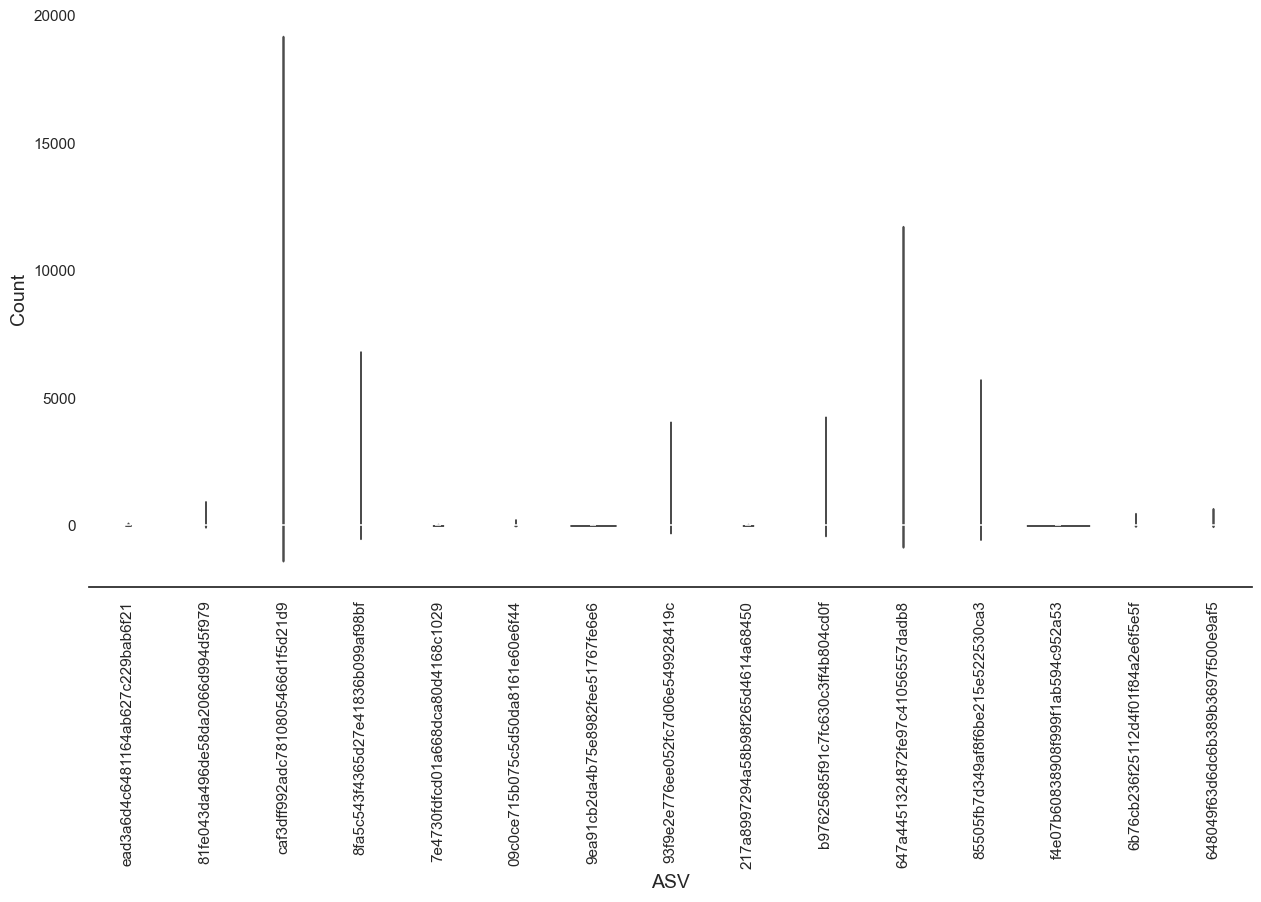

In [8]:
with sns.axes_style('white'), sns.color_palette('Set1'):
    fig, ax = plt.subplots()
    fig.set_size_inches(15, 7.5)
    
    sns.violinplot(data=data_plot, x='asv', y='count', ax=ax)
    sns.despine(left=True)
    
    # adjust tick labels and axes titles
    ax.tick_params(axis='x', rotation=90, labelsize=11)
    ax.tick_params(axis='y', labelsize=11)
    ax.set_xlabel('ASV', fontsize=14)
    ax.set_ylabel('Count', fontsize=14)

The plot shows most values clustering around 0, with only a few differing. To quantify this pattern across **all ASVs** (not just 15!!!), we can test for data normality using Shapiro-Wilk test.

In [9]:
alpha = 0.05
results = {}

# iterate through rows (samples) and test each of them for normality
for asv_name, asv_values in data.items():
    stat, p = shapiro(asv_values)
    results[asv_name] = p

# convert test results into a DataFrame
results_df = pd.DataFrame(data=results.values(), index=results.keys(), columns=['p'])

# add a new column with a descriptive test result
results_df['is_normal'] = results_df['p'] > alpha

Visualize:

In [10]:
results_df

,p,is_normal
65c81b7f020fa6530e5995cfadbed4b8,2.074308e-22,False
3b5167fc05d221e402cb1748506b8442,2.074308e-22,False
8b03f72e05e140685a739928d4dd2619,2.074308e-22,False
dc5e130892eb358854eb477a790f8af9,2.074308e-22,False
9b4ec0ce1b21a5a1172c2f0452d9f241,2.074308e-22,False
...,...,...
049818b152db3312886899302aa53e00,2.074308e-22,False
0804cc0c3a3cb43a50c6272ab93f6e67,2.074308e-22,False
7553d3ce1a630921aa4ec5bc5298421a,2.074308e-22,False
c04bf7fb221724977d918399c366696f,2.074308e-22,False


To identify ASVs with a normal distribution, sum the values in the is_normal column. Since True equals 1 and False equals 0, a sum greater than 0 indicates the presence of normally distributed ASVs.

In [11]:
print('Number of ASVs with normal distribution:', results_df['is_normal'].sum())

Number of ASVs with normal distribution: 0


None is normally distributed! So we cannot use the common parametric tests.

In [12]:
meta = pd.read_csv(f"{raw_data_dir}/metadata.tsv", sep="\t")
meta.head()

,Sample_Name,Patient_ID,Stool_Consistency,Patient_Sex,Sample_Day,Recovery_Day,Cohort_Number
0,EG2580,P042,liquid,F,13,17.0,2
1,EG2559,P043,liquid,M,15,17.0,2
2,EG2537,P042,liquid,F,0,17.0,1
3,EG2518,P043,liquid,M,0,17.0,1
4,EG2490,P030,formed,F,0,NaN,1


<a id='ancom'></a>
## 2. ANCOM

To address the dataset's limitations, we’ll start by filtering the feature table. Only features with a minimum frequency of 25 and presence in at least 5 samples will be retained. This helps improve resolution and minimizes the false discovery rate (FDR) penalty for features below the noise threshold. `filter-features` action from the `feature-table` plugin is used and applied to the filtered `FeatureTable` from `01_data_download_and_preprocessing.ipynb`. We first, however, visualize the filtered table to estimate which parameters to use for filtering:

In [13]:
! qiime feature-table summarize \
  --i-table $data_dir/table-filtered.qza \
  --o-visualization $data_dir/table-filtered.qzv


Saved Visualization to: ../data/processed/table-filtered.qzv
Press the 'q' key, Control-C, or Control-D to quit. This view may no longer be accessible or work correctly after quitting.
Press the 'q' key, Control-C, or Control-D to quit. This view may no longer be accessible or work correctly after quitting.

In [ ]:
! qiime tools view $data_dir/table-filtered.qzv

We can see that the features with a lower frequency (<20) are present mostly in just one, or at most 2 samples, therefore we are filtering them off. Also, features that are only present in one sample cannot be compared across them, so we filter them off also. 

In [14]:
! qiime feature-table filter-features \
    --i-table $data_dir/table-filtered.qza \
    --p-min-frequency 20 \
    --p-min-samples 2 \
    --o-filtered-table $data_dir/table_abund.qza

Saved FeatureTable[Frequency] to: ../data/processed/table_abund.qza


In [15]:
! qiime feature-table summarize \
  --i-table $data_dir/table_abund.qza \
  --o-visualization $data_dir/table_abund.qzv

Saved Visualization to: ../data/processed/table_abund.qzv


In [26]:
!qiime tools view $data_dir/table_abund.qzv

Press the 'q' key, Control-C, or Control-D to quit. This view may no longer be accessible or work correctly after quitting.
Press the 'q' key, Control-C, or Control-D to quit. This view may no longer be accessible or work correctly after quitting.

Collapse the results to the **species** level:

In [16]:
! qiime taxa collapse \
    --i-table $data_dir/table_abund.qza \
    --i-taxonomy $data_dir/taxonomy.qza \
    --p-level 7 \
    --o-collapsed-table $data_dir/table_abund_l7.qza

Saved FeatureTable[Frequency] to: ../data/processed/table_abund_l7.qza


Collapse the results to the **genus** level:

In [18]:
! qiime taxa collapse \
    --i-table $data_dir/table_abund.qza \
    --i-taxonomy $data_dir/taxonomy.qza \
    --p-level 6 \
    --o-collapsed-table $data_dir/table_abund_l6.qza

Saved FeatureTable[Frequency] to: ../data/processed/table_abund_l6.qza


Collapse the results to the **family** level:

In [19]:
! qiime taxa collapse \
    --i-table $data_dir/table_abund.qza \
    --i-taxonomy $data_dir/taxonomy.qza \
    --p-level 5 \
    --o-collapsed-table $data_dir/table_abund_l5.qza

Saved FeatureTable[Frequency] to: ../data/processed/table_abund_l5.qza


Collapse the results to the **order** level:

In [20]:
! qiime taxa collapse \
    --i-table $data_dir/table_abund.qza \
    --i-taxonomy $data_dir/taxonomy.qza \
    --p-level 4 \
    --o-collapsed-table $data_dir/table_abund_l4.qza

Saved FeatureTable[Frequency] to: ../data/processed/table_abund_l4.qza


Collapse the results to the **class** level:

In [21]:
! qiime taxa collapse \
    --i-table $data_dir/table_abund.qza \
    --i-taxonomy $data_dir/taxonomy.qza \
    --p-level 3 \
    --o-collapsed-table $data_dir/table_abund_l3.qza

Saved FeatureTable[Frequency] to: ../data/processed/table_abund_l3.qza


Collapse the results to the **phylum** level:

In [22]:
! qiime taxa collapse \
    --i-table $data_dir/table_abund.qza \
    --i-taxonomy $data_dir/taxonomy.qza \
    --p-level 2 \
    --o-collapsed-table $data_dir/table_abund_l2.qza

Saved FeatureTable[Frequency] to: ../data/processed/table_abund_l2.qza


### Stool Consistency

We will try to first find taxa differentially abundant in the different stool consistencies:  *liquid*, *formed* and *semi-formed*. 

In [23]:
# Run ANCOM-BC
! qiime composition ancombc \
    --i-table $data_dir/table_abund.qza \
    --m-metadata-file $data_dir/metadata.tsv \
    --p-formula Stool_Consistency \
    --o-differentials $data_dir/ancombc_stool_consistency_differentials.qza

# Generate a barplot of differentially abundant taxa between environments
! qiime composition da-barplot \
    --i-data $data_dir/ancombc_stool_consistency_differentials.qza \
    --o-visualization $data_dir/ancombc_stool_consistency_da_barplot.qzv

# Generate a table of these same values for all taxa
! qiime composition tabulate \
    --i-data $data_dir/ancombc_stool_consistency_differentials.qza \
    --o-visualization $data_dir/ancombc_stool_consistency_results.qzv

Saved FeatureData[DifferentialAbundance] to: ../data/processed/ancombc_stool_consistency_differentials.qza
Saved Visualization to: ../data/processed/ancombc_stool_consistency_da_barplot.qzv
Saved Visualization to: ../data/processed/ancombc_stool_consistency_results.qzv


The results are visualized in the following cell. The barplot `ancombc_stool_consistency_da_barplot.qzv` displayed which features are enriched or depleted in each group. We are comparing *liquid*, *formed* and *semi-formed*, and *liquid* and  *semi-formed* are used as the comparison group and the *formed*  as the reference group. So the features that are more abundant in the *formed* are shown as enriched (blue bars), and features that are more abundant in gut samples are shown as depleted (orange bars). 

In [ ]:
! qiime tools view $data_dir/ancombc_stool_consistency_da_barplot.qzv

Press the 'q' key, Control-C, or Control-D to quit. This view may no longer be accessible or work correctly after quitting.
Press the 'q' key, Control-C, or Control-D to quit. This view may no longer be accessible or work correctly after quitting.

In [ ]:
! qiime tools view $data_dir/ancombc_stool_consistency_results.qzv

Press the 'q' key, Control-C, or Control-D to quit. This view may no longer be accessible or work correctly after quitting.
Press the 'q' key, Control-C, or Control-D to quit. This view may no longer be accessible or work correctly after quitting.

I will repeat the same thing for all of the taxonomy orders:

In [24]:
# Define the data directory and levels
levels = ["l7", "l6", "l5", "l4", "l3", "l2"]


# Loop through the levels and run the commands
for level in levels:
    try:
        print(f"Running commands for level: {level}")
        
        # Run ANCOM-BC
        subprocess.run([
            "qiime", "composition", "ancombc",
            "--i-table", f"{data_dir}/table_abund_{level}.qza",
            "--m-metadata-file", f"{data_dir}/metadata.tsv",
            "--p-formula", "Stool_Consistency",
            "--o-differentials", f"{data_dir}/ancombc_stool_consistency_{level}_differentials.qza"
        ], check=True)
        
        # Generate a barplot
        subprocess.run([
            "qiime", "composition", "da-barplot",
            "--i-data", f"{data_dir}/ancombc_stool_consistency_{level}_differentials.qza",
            "--o-visualization", f"{data_dir}/ancombc_stool_consistency_{level}_barplot.qzv"
        ], check=True)
        
        # Generate a results table
        subprocess.run([
            "qiime", "composition", "tabulate",
            "--i-data", f"{data_dir}/ancombc_stool_consistency_{level}_differentials.qza",
            "--o-visualization", f"{data_dir}/ancombc_stool_consistency_{level}_results.qzv"
        ], check=True)
        
        print(f"Commands for level {level} completed successfully!")
    except subprocess.CalledProcessError as e:
        print(f"Error running commands for level {level}: {e}")


Running commands for level: l7
Saved FeatureData[DifferentialAbundance] to: ../data/processed/ancombc_stool_consistency_l7_differentials.qza
Saved Visualization to: ../data/processed/ancombc_stool_consistency_l7_barplot.qzv
Saved Visualization to: ../data/processed/ancombc_stool_consistency_l7_results.qzv
Commands for level l7 completed successfully!
Running commands for level: l6
Saved FeatureData[DifferentialAbundance] to: ../data/processed/ancombc_stool_consistency_l6_differentials.qza
Saved Visualization to: ../data/processed/ancombc_stool_consistency_l6_barplot.qzv
Saved Visualization to: ../data/processed/ancombc_stool_consistency_l6_results.qzv
Commands for level l6 completed successfully!
Running commands for level: l5
Saved FeatureData[DifferentialAbundance] to: ../data/processed/ancombc_stool_consistency_l5_differentials.qza
Saved Visualization to: ../data/processed/ancombc_stool_consistency_l5_barplot.qzv
Saved Visualization to: ../data/processed/ancombc_stool_consistency_l5

### Sex

We are comparing *male* and *female* are compared, *male* are used as the comparison group and the *female*  as the reference group. So the features that are more abundant in the *male* are shown as enriched (blue bars), and features that are more abundant in gut samples are shown as depleted (orange bars). 

In [25]:
# Run ANCOM-BC
! qiime composition ancombc \
    --i-table $data_dir/table_abund.qza \
    --m-metadata-file $data_dir/metadata.tsv \
    --p-formula Patient_Sex \
    --o-differentials $data_dir/ancombc_sex_differentials.qza

# Generate a barplot of differentially abundant taxa between environments
! qiime composition da-barplot \
    --i-data $data_dir/ancombc_sex_differentials.qza \
    --o-visualization $data_dir/ancombc_sex_da_barplot.qzv

# Generate a table of these same values for all taxa
! qiime composition tabulate \
    --i-data $data_dir/ancombc_sex_differentials.qza \
    --o-visualization $data_dir/ancombc_sex_results.qzv

Saved FeatureData[DifferentialAbundance] to: ../data/processed/ancombc_sex_differentials.qza
Saved Visualization to: ../data/processed/ancombc_sex_da_barplot.qzv
Saved Visualization to: ../data/processed/ancombc_sex_results.qzv


In [38]:
! qiime tools view $data_dir/ancombc_sex_da_barplot.qzv

Press the 'q' key, Control-C, or Control-D to quit. This view may no longer be accessible or work correctly after quitting.
Press the 'q' key, Control-C, or Control-D to quit. This view may no longer be accessible or work correctly after quitting.

In [ ]:
! qiime tools view $data_dir/ancombc_sex_results.qzv

In [26]:
levels = ["l7", "l6", "l5", "l4", "l3", "l2"]

# Loop through the levels and run the commands
for level in levels:
    try:
        print(f"Running commands for level: {level}")
        
        # Run ANCOM-BC
        subprocess.run([
            "qiime", "composition", "ancombc",
            "--i-table", f"{data_dir}/table_abund_{level}.qza",
            "--m-metadata-file", f"{data_dir}/metadata.tsv",
            "--p-formula", "Patient_Sex",
            "--o-differentials", f"{data_dir}/ancombc_sex_{level}_differentials.qza"
        ], check=True)
        
        # Generate a barplot
        subprocess.run([
            "qiime", "composition", "da-barplot",
            "--i-data", f"{data_dir}/ancombc_sex_{level}_differentials.qza",
            "--o-visualization", f"{data_dir}/ancombc_sex_{level}_barplot.qzv"
        ], check=True)
        
        # Generate a results table
        subprocess.run([
            "qiime", "composition", "tabulate",
            "--i-data", f"{data_dir}/ancombc_sex_{level}_differentials.qza",
            "--o-visualization", f"{data_dir}/ancombc_sex_{level}_results.qzv"
        ], check=True)
        
        print(f"Commands for level {level} completed successfully!")
    except subprocess.CalledProcessError as e:
        print(f"Error running commands for level {level}: {e}")

Running commands for level: l7
Saved FeatureData[DifferentialAbundance] to: ../data/processed/ancombc_sex_l7_differentials.qza
Saved Visualization to: ../data/processed/ancombc_sex_l7_barplot.qzv
Saved Visualization to: ../data/processed/ancombc_sex_l7_results.qzv
Commands for level l7 completed successfully!
Running commands for level: l6
Saved FeatureData[DifferentialAbundance] to: ../data/processed/ancombc_sex_l6_differentials.qza
Saved Visualization to: ../data/processed/ancombc_sex_l6_barplot.qzv
Saved Visualization to: ../data/processed/ancombc_sex_l6_results.qzv
Commands for level l6 completed successfully!
Running commands for level: l5
Saved FeatureData[DifferentialAbundance] to: ../data/processed/ancombc_sex_l5_differentials.qza
Saved Visualization to: ../data/processed/ancombc_sex_l5_barplot.qzv
Saved Visualization to: ../data/processed/ancombc_sex_l5_results.qzv
Commands for level l5 completed successfully!
Running commands for level: l4
Saved FeatureData[DifferentialAbunda

## 3. Result analysis - finding differentially abundant features

### Stool consistency

#### Overalll differentials

In [27]:
def process_ancombc_results(data_dir, filename, column_names):
    """
    Processes ANCOM-BC results from a specified file and extracts LFC, p-values, and q-values.
    Iterates through multiple column names to check for significant q-values.

    Parameters:
        data_dir (str): Path to the directory containing the ANCOM-BC result file.
        filename (str): Name of the ANCOM-BC result file (e.g., 'ancombc_sex_differentials.qza').
        column_names (list): List of column names to check q-values for (e.g., ['Patient_SexM', 'Patient_SexF']).

    Returns:
        pd.DataFrame: DataFrame containing concatenated LFC, p-values, and q-values.
    """
    # Load the ANCOM-BC results artifact
    dirfmt = q2.Artifact.load(f'{data_dir}/{filename}')
    dirfmt = dirfmt.view(DataLoafPackageDirFmt)

    # Extract data slices
    slices = {}
    for relpath, view in dirfmt.data_slices.iter_views(pd.DataFrame):
        slices[str(relpath)] = view

    # Extract LFC, p-values, and q-values
    lfc = list(slices.values())[0]
    lfc.set_index(lfc.columns[0], inplace=True)
    lfc.columns = ['lfc_' + col for col in lfc.columns]

    p_val = list(slices.values())[1]
    p_val.set_index(p_val.columns[0], inplace=True)
    p_val.columns = ['p_val_' + col for col in p_val.columns]

    q_val = list(slices.values())[2]
    q_val.set_index(q_val.columns[0], inplace=True)
    q_val.columns = ['q_val_' + col for col in q_val.columns]

    # Combine into a single DataFrame
    result_df = pd.concat([lfc, p_val, q_val], axis=1, join='inner')

    # Check q-values for each column and print results
    for column_name in column_names:
        if f'q_val_{column_name}' in result_df.columns:
            significant_count = len(result_df.loc[result_df[f'q_val_{column_name}'] <= 0.05])
            print(f"Total significant features for {column_name}: {significant_count}")
        else:
            print(f"Column {column_name} not found in the results.")

    return result_df

In [28]:
process_ancombc_results(data_dir, 'ancombc_stool_consistency_differentials.qza', ['Stool_Consistencyliquid', "Stool_Consistencysemi-formed"])

Total significant features for Stool_Consistencyliquid: 0
Total significant features for Stool_Consistencysemi-formed: 0


,lfc_(Intercept),lfc_Stool_Consistencyliquid,lfc_Stool_Consistencysemi-formed,p_val_(Intercept),p_val_Stool_Consistencyliquid,p_val_Stool_Consistencysemi-formed,q_val_(Intercept),q_val_Stool_Consistencyliquid,q_val_Stool_Consistencysemi-formed
id,,,,,,,,,
b20c29c87760a4c52017e2127abe5f90,0.942244,-0.110145,0.224788,0.063072,0.865257,0.735053,1.000000,1,1
021d20ef6395eeaa65f3f77a8499a7e2,1.385854,-0.104717,0.204264,0.000301,0.846580,0.713053,0.033117,1,1
b97625685f91c7fc630c3ff4b804cd0f,0.139295,-0.164228,-0.307516,0.659208,0.724699,0.488140,1.000000,1,1
5a8ae2cd795169a4cf43c876b48a303c,0.425680,0.176772,0.046185,0.412695,0.786343,0.942816,1.000000,1,1
1ccabe6915d504aba83616f13828683a,0.902716,-0.518355,-0.381523,0.033858,0.310657,0.469153,1.000000,1,1
...,...,...,...,...,...,...,...,...,...
2d9cbcbd3edbccfb6026976a8eeaf12f,0.122797,-0.276742,-0.010131,0.695601,0.490822,0.982845,1.000000,1,1
9684806e99b3e7c9f20814348f9953f7,-0.010237,0.044415,0.036276,0.981765,0.934247,0.943672,1.000000,1,1
69efeea4decc3783aecb9cfe340f4261,0.104496,-0.065676,0.246039,0.764952,0.894999,0.635619,1.000000,1,1


#### Taxonomical levels

In [29]:

# Define the data directory and taxonomy levels
taxonomy_levels = {
    "l7": "species",
    "l6": "genus",
    "l5": "family",
    "l4": "order",
    "l3": "class",
    "l2": "phylum"
}

# Initialize a dictionary to store results
results = {}

# Iterate through each taxonomy level
for level, name in taxonomy_levels.items():
    print(f"Processing taxonomy level: {name} ({level})")
    

    # Calculate the differentials and store the results
    df = process_ancombc_results(data_dir, f'ancombc_stool_consistency_{level}_differentials.qza', ['Stool_Consistencyliquid', "Stool_Consistencysemi-formed"])

    # Count significant features for each stool consistency
    liquid_significant = len(df.loc[df['q_val_Stool_Consistencyliquid'] <= 0.05])
    semi_formed_significant = len(df.loc[df['q_val_Stool_Consistencysemi-formed'] <= 0.05])

    # Store the results
    results[level] = {
        "taxonomy_level": name,
        "liquid_significant": liquid_significant,
        "semi_formed_significant": semi_formed_significant
    }


# Convert results to a DataFrame for better visualization
results_df = pd.DataFrame.from_dict(results, orient='index')

# Display the results
print(results_df)


Processing taxonomy level: species (l7)
Total significant features for Stool_Consistencyliquid: 0
Total significant features for Stool_Consistencysemi-formed: 0
Processing taxonomy level: genus (l6)
Total significant features for Stool_Consistencyliquid: 0
Total significant features for Stool_Consistencysemi-formed: 0
Processing taxonomy level: family (l5)
Total significant features for Stool_Consistencyliquid: 0
Total significant features for Stool_Consistencysemi-formed: 1
Processing taxonomy level: order (l4)
Total significant features for Stool_Consistencyliquid: 0
Total significant features for Stool_Consistencysemi-formed: 0
Processing taxonomy level: class (l3)
Total significant features for Stool_Consistencyliquid: 0
Total significant features for Stool_Consistencysemi-formed: 0
Processing taxonomy level: phylum (l2)
Total significant features for Stool_Consistencyliquid: 0
Total significant features for Stool_Consistencysemi-formed: 0
   taxonomy_level  liquid_significant  sem

We found **1 differentially expressed** features at family level. 

In [30]:
df = process_ancombc_results(data_dir, f'ancombc_stool_consistency_l5_differentials.qza', ['Stool_Consistencyliquid', "Stool_Consistencysemi-formed"])
df.loc[df['q_val_Stool_Consistencysemi-formed'] <= 0.05]

Total significant features for Stool_Consistencyliquid: 0
Total significant features for Stool_Consistencysemi-formed: 1


,lfc_(Intercept),lfc_Stool_Consistencyliquid,lfc_Stool_Consistencysemi-formed,p_val_(Intercept),p_val_Stool_Consistencyliquid,p_val_Stool_Consistencysemi-formed,q_val_(Intercept),q_val_Stool_Consistencyliquid,q_val_Stool_Consistencysemi-formed
id,,,,,,,,,
d__Bacteria;p__Firmicutes;c__Clostridia;o__Oscillospirales;f__Butyricicoccaceae,-0.67606,0.837212,1.012451,0.000179,0.003175,0.001398,0.002863,0.101606,0.044721


It is **d__Bacteria;p__Firmicutes;c__Clostridia;o__Oscillospirales;f__Butyricicoccaceae**.

### Sex

#### Overalll differentials

In [31]:
process_ancombc_results(data_dir, 'ancombc_sex_differentials.qza', ['Patient_SexM', ])

Total significant features for Patient_SexM: 0


,lfc_(Intercept),lfc_Patient_SexM,p_val_(Intercept),p_val_Patient_SexM,q_val_(Intercept),q_val_Patient_SexM
id,,,,,,
b20c29c87760a4c52017e2127abe5f90,1.018852,-0.139859,2.851701e-03,0.784980,0.296577,1
021d20ef6395eeaa65f3f77a8499a7e2,1.756608,-0.726894,4.481012e-07,0.104022,0.000053,1
b97625685f91c7fc630c3ff4b804cd0f,-0.108533,0.100811,7.288980e-01,0.790271,1.000000,1
5a8ae2cd795169a4cf43c876b48a303c,0.245939,0.441400,4.569631e-01,0.370240,1.000000,1
1ccabe6915d504aba83616f13828683a,0.538504,0.034127,5.563238e-02,0.930727,1.000000,1
...,...,...,...,...,...,...
2d9cbcbd3edbccfb6026976a8eeaf12f,0.270716,-0.553193,3.608469e-01,0.117907,1.000000,1
9684806e99b3e7c9f20814348f9953f7,-0.189848,0.342846,4.544062e-01,0.370302,1.000000,1
69efeea4decc3783aecb9cfe340f4261,0.649355,-1.013261,6.317810e-02,0.014098,1.000000,1


#### Taxonomical levels

In [32]:
taxonomy_levels = {
    "l7": "species",
    "l6": "genus",
    "l5": "family",
    "l4": "order",
    "l3": "class",
    "l2": "phylum"
}

# Initialize a dictionary to store results
results = {}

# Iterate through each taxonomy level
for level, name in taxonomy_levels.items():
    print(f"Processing taxonomy level: {name} ({level})")
    
    # Calculate the differentials and store the results
    df = process_ancombc_results(data_dir, f'ancombc_sex_{level}_differentials.qza', ['Stool_Consistencyliquid', "Stool_Consistencysemi-formed"])

    # Count significant features for males
    male_significant = len(df.loc[df['q_val_Patient_SexM'] <= 0.05])

    # Store the results
    results[level] = {
        "taxonomy_level": name,
        "male_significant": male_significant,
    }

# Convert results to a DataFrame for better visualization
results_df = pd.DataFrame.from_dict(results, orient='index')

# Display the results
print(results_df)

Processing taxonomy level: species (l7)
Column Stool_Consistencyliquid not found in the results.
Column Stool_Consistencysemi-formed not found in the results.
Processing taxonomy level: genus (l6)
Column Stool_Consistencyliquid not found in the results.
Column Stool_Consistencysemi-formed not found in the results.
Processing taxonomy level: family (l5)
Column Stool_Consistencyliquid not found in the results.
Column Stool_Consistencysemi-formed not found in the results.
Processing taxonomy level: order (l4)
Column Stool_Consistencyliquid not found in the results.
Column Stool_Consistencysemi-formed not found in the results.
Processing taxonomy level: class (l3)
Column Stool_Consistencyliquid not found in the results.
Column Stool_Consistencysemi-formed not found in the results.
Processing taxonomy level: phylum (l2)
Column Stool_Consistencyliquid not found in the results.
Column Stool_Consistencysemi-formed not found in the results.
   taxonomy_level  male_significant
l7        species 

Based on these two categorical features, there are **no differentially** expressed features.

## 4. Troubleshooting

### Not filtered table

Here, I tried taking the  `table-filtered.qza` directly, without filtering off any of the features based on their prevalence in different samples or their frequency. However, still no results. 

In [33]:
# Run ANCOM-BC
! qiime composition ancombc \
    --i-table $data_dir/table-filtered.qza \
    --m-metadata-file $data_dir/metadata.tsv \
    --p-formula Stool_Consistency \
    --o-differentials $data_dir/not_filtered_ancombc_stool_consistency_differentials.qza

# Generate a barplot of differentially abundant taxa between environments
! qiime composition da-barplot \
    --i-data $data_dir/ancombc_stool_consistency_differentials.qza \
    --o-visualization $data_dir/not_filtered_ancombc_stool_consistency_da_barplot.qzv

# Generate a table of these same values for all taxa
! qiime composition tabulate \
    --i-data $data_dir/ancombc_stool_consistency_differentials.qza \
    --o-visualization $data_dir/not_filtered_ancombc_stool_consistency_results.qzv

Saved FeatureData[DifferentialAbundance] to: ../data/processed/not_filtered_ancombc_stool_consistency_differentials.qza
Saved Visualization to: ../data/processed/not_filtered_ancombc_stool_consistency_da_barplot.qzv
Saved Visualization to: ../data/processed/not_filtered_ancombc_stool_consistency_results.qzv


In [34]:
process_ancombc_results(data_dir, 'not_filtered_ancombc_stool_consistency_differentials.qza', ['Stool_Consistencyliquid', "Stool_Consistencysemi-formed"])

Total significant features for Stool_Consistencyliquid: 0
Total significant features for Stool_Consistencysemi-formed: 0


,lfc_(Intercept),lfc_Stool_Consistencyliquid,lfc_Stool_Consistencysemi-formed,p_val_(Intercept),p_val_Stool_Consistencyliquid,p_val_Stool_Consistencysemi-formed,q_val_(Intercept),q_val_Stool_Consistencyliquid,q_val_Stool_Consistencysemi-formed
id,,,,,,,,,
b20c29c87760a4c52017e2127abe5f90,0.942244,-0.110145,0.224788,0.063072,0.865257,0.735053,1.000000,1,1
021d20ef6395eeaa65f3f77a8499a7e2,1.385854,-0.104717,0.204264,0.000301,0.846580,0.713053,0.033117,1,1
b97625685f91c7fc630c3ff4b804cd0f,0.139295,-0.164228,-0.307516,0.659208,0.724699,0.488140,1.000000,1,1
5a8ae2cd795169a4cf43c876b48a303c,0.425680,0.176772,0.046185,0.412695,0.786343,0.942816,1.000000,1,1
1ccabe6915d504aba83616f13828683a,0.902716,-0.518355,-0.381523,0.033858,0.310657,0.469153,1.000000,1,1
...,...,...,...,...,...,...,...,...,...
2d9cbcbd3edbccfb6026976a8eeaf12f,0.122797,-0.276742,-0.010131,0.695601,0.490822,0.982845,1.000000,1,1
9684806e99b3e7c9f20814348f9953f7,-0.010237,0.044415,0.036276,0.981765,0.934247,0.943672,1.000000,1,1
69efeea4decc3783aecb9cfe340f4261,0.104496,-0.065676,0.246039,0.764952,0.894999,0.635619,1.000000,1,1


In [35]:
# Run ANCOM-BC
! qiime composition ancombc \
    --i-table $data_dir/table-filtered.qza \
    --m-metadata-file $data_dir/metadata.tsv \
    --p-formula Patient_Sex \
    --o-differentials $data_dir/not_filtered_ancombc_sex_differentials.qza

# Generate a barplot of differentially abundant taxa between environments
! qiime composition da-barplot \
    --i-data $data_dir/ancombc_sex_differentials.qza \
    --o-visualization $data_dir/not_filtered_ancombc_sex_da_barplot.qzv

# Generate a table of these same values for all taxa
! qiime composition tabulate \
    --i-data $data_dir/ancombc_sex_differentials.qza \
    --o-visualization $data_dir/not_filtered_ancombc_sex_results.qzv

Saved FeatureData[DifferentialAbundance] to: ../data/processed/not_filtered_ancombc_sex_differentials.qza
Saved Visualization to: ../data/processed/not_filtered_ancombc_sex_da_barplot.qzv
Saved Visualization to: ../data/processed/not_filtered_ancombc_sex_results.qzv


In [36]:
process_ancombc_results(data_dir, 'not_filtered_ancombc_sex_differentials.qza',  ['Patient_SexM', ])

Total significant features for Patient_SexM: 0


,lfc_(Intercept),lfc_Patient_SexM,p_val_(Intercept),p_val_Patient_SexM,q_val_(Intercept),q_val_Patient_SexM
id,,,,,,
b20c29c87760a4c52017e2127abe5f90,1.018852,-0.139859,2.851701e-03,0.784980,0.296577,1
021d20ef6395eeaa65f3f77a8499a7e2,1.756608,-0.726894,4.481012e-07,0.104022,0.000053,1
b97625685f91c7fc630c3ff4b804cd0f,-0.108533,0.100811,7.288980e-01,0.790271,1.000000,1
5a8ae2cd795169a4cf43c876b48a303c,0.245939,0.441400,4.569631e-01,0.370240,1.000000,1
1ccabe6915d504aba83616f13828683a,0.538504,0.034127,5.563238e-02,0.930727,1.000000,1
...,...,...,...,...,...,...
2d9cbcbd3edbccfb6026976a8eeaf12f,0.270716,-0.553193,3.608469e-01,0.117907,1.000000,1
9684806e99b3e7c9f20814348f9953f7,-0.189848,0.342846,4.544062e-01,0.370302,1.000000,1
69efeea4decc3783aecb9cfe340f4261,0.649355,-1.013261,6.317810e-02,0.014098,1.000000,1


I tried separating the tables into different cohorts. Maybe there is differential abundance of features across different stools consistencies or sex inside one cohort?

### Cohort 1

In [37]:
! qiime feature-table filter-samples \
    --i-table $data_dir/table_abund.qza \
    --m-metadata-file $data_dir/metadata.tsv \
    --p-where "[Cohort_Number]=1" \
    --o-filtered-table $data_dir/table_abund_cohort_1.qza
    
# Run ANCOM-BC
! qiime composition ancombc \
    --i-table $data_dir/table_abund_cohort_1.qza \
    --m-metadata-file $data_dir/metadata.tsv \
    --p-formula Stool_Consistency \
    --o-differentials $data_dir/cohort_1_ancombc_stool_consistency_differentials.qza

# Generate a barplot of differentially abundant taxa between environments
! qiime composition da-barplot \
    --i-data $data_dir/ancombc_stool_consistency_differentials.qza \
    --o-visualization $data_dir/cohort_1_ancombc_stool_consistency_da_barplot.qzv

# Generate a table of these same values for all taxa
! qiime composition tabulate \
    --i-data $data_dir/ancombc_stool_consistency_differentials.qza \
    --o-visualization $data_dir/cohort_1_ancombc_stool_consistency_results.qzv

Saved FeatureTable[Frequency] to: ../data/processed/table_abund_cohort_1.qza
Saved FeatureData[DifferentialAbundance] to: ../data/processed/cohort_1_ancombc_stool_consistency_differentials.qza
Saved Visualization to: ../data/processed/cohort_1_ancombc_stool_consistency_da_barplot.qzv
Saved Visualization to: ../data/processed/cohort_1_ancombc_stool_consistency_results.qzv


In [38]:
process_ancombc_results(data_dir, 'cohort_1_ancombc_stool_consistency_differentials.qza', ['Stool_Consistencyliquid', "Stool_Consistencysemi-formed"])

Total significant features for Stool_Consistencyliquid: 0
Total significant features for Stool_Consistencysemi-formed: 0


,lfc_(Intercept),lfc_Stool_Consistencyliquid,lfc_Stool_Consistencysemi-formed,p_val_(Intercept),p_val_Stool_Consistencyliquid,p_val_Stool_Consistencysemi-formed,q_val_(Intercept),q_val_Stool_Consistencyliquid,q_val_Stool_Consistencysemi-formed
id,,,,,,,,,
7bac8a005b18e6d4507c603114e28037,-0.351387,0.330878,0.475806,2.614179e-01,0.477261,0.395246,1.000000e+00,1,1
3e60c8db6b7067aca557556cbee389e3,-0.078376,-0.094827,1.042801,8.260740e-01,0.855434,0.194818,1.000000e+00,1,1
b20c29c87760a4c52017e2127abe5f90,0.941195,0.269644,0.754736,1.915184e-01,0.769419,0.413569,1.000000e+00,1,1
d6a24527ce670dc047eaa0247b4d0302,-0.087228,0.337125,0.836517,8.827876e-01,0.673217,0.343664,1.000000e+00,1,1
021d20ef6395eeaa65f3f77a8499a7e2,2.154627,-0.922017,0.487426,3.047479e-04,0.242496,0.578475,5.150239e-02,1,1
...,...,...,...,...,...,...,...,...,...
ae41c1661c10ff3e45896af07e3fb9a9,-0.539100,0.348486,-0.073548,1.534644e-02,0.342916,0.814840,1.000000e+00,1,1
44418f00697afbefe5c7227026e40e13,-0.699409,1.449139,0.933976,9.068760e-10,0.028498,0.055017,1.831889e-07,1,1
d1fdc0028a5c16d0a24d5213825bcd7a,0.219764,-0.104805,1.689318,6.396332e-01,0.853716,0.051899,1.000000e+00,1,1


In [39]:
# Run ANCOM-BC
! qiime composition ancombc \
    --i-table $data_dir/table_abund_cohort_1.qza \
    --m-metadata-file $data_dir/metadata.tsv \
    --p-formula Patient_Sex \
    --o-differentials $data_dir/cohort_1_ancombc_sex_differentials.qza

# Generate a barplot of differentially abundant taxa between environments
! qiime composition da-barplot \
    --i-data $data_dir/ancombc_sex_differentials.qza \
    --o-visualization $data_dir/cohort_1_ancombc_sex_da_barplot.qzv

# Generate a table of these same values for all taxa
! qiime composition tabulate \
    --i-data $data_dir/ancombc_sex_differentials.qza \
    --o-visualization $data_dir/cohort_1_ancombc_sex_results.qzv

Saved FeatureData[DifferentialAbundance] to: ../data/processed/cohort_1_ancombc_sex_differentials.qza
Saved Visualization to: ../data/processed/cohort_1_ancombc_sex_da_barplot.qzv
Saved Visualization to: ../data/processed/cohort_1_ancombc_sex_results.qzv


In [40]:
process_ancombc_results(data_dir, 'not_filtered_ancombc_sex_differentials.qza',  ['Patient_SexM', ])

Total significant features for Patient_SexM: 0


,lfc_(Intercept),lfc_Patient_SexM,p_val_(Intercept),p_val_Patient_SexM,q_val_(Intercept),q_val_Patient_SexM
id,,,,,,
b20c29c87760a4c52017e2127abe5f90,1.018852,-0.139859,2.851701e-03,0.784980,0.296577,1
021d20ef6395eeaa65f3f77a8499a7e2,1.756608,-0.726894,4.481012e-07,0.104022,0.000053,1
b97625685f91c7fc630c3ff4b804cd0f,-0.108533,0.100811,7.288980e-01,0.790271,1.000000,1
5a8ae2cd795169a4cf43c876b48a303c,0.245939,0.441400,4.569631e-01,0.370240,1.000000,1
1ccabe6915d504aba83616f13828683a,0.538504,0.034127,5.563238e-02,0.930727,1.000000,1
...,...,...,...,...,...,...
2d9cbcbd3edbccfb6026976a8eeaf12f,0.270716,-0.553193,3.608469e-01,0.117907,1.000000,1
9684806e99b3e7c9f20814348f9953f7,-0.189848,0.342846,4.544062e-01,0.370302,1.000000,1
69efeea4decc3783aecb9cfe340f4261,0.649355,-1.013261,6.317810e-02,0.014098,1.000000,1


### Cohort 2

In [41]:
! qiime feature-table filter-samples \
    --i-table $data_dir/table_abund.qza \
    --m-metadata-file $data_dir/metadata.tsv \
    --p-where "[Cohort_Number]=2" \
    --o-filtered-table $data_dir/table_abund_cohort_2.qza
    
# Run ANCOM-BC
! qiime composition ancombc \
    --i-table $data_dir/table_abund_cohort_2.qza \
    --m-metadata-file $data_dir/metadata.tsv \
    --p-formula Stool_Consistency \
    --o-differentials $data_dir/cohort_2_ancombc_stool_consistency_differentials.qza

# Generate a barplot of differentially abundant taxa between environments
! qiime composition da-barplot \
    --i-data $data_dir/ancombc_stool_consistency_differentials.qza \
    --o-visualization $data_dir/cohort_2_ancombc_stool_consistency_da_barplot.qzv

# Generate a table of these same values for all taxa
! qiime composition tabulate \
    --i-data $data_dir/ancombc_stool_consistency_differentials.qza \
    --o-visualization $data_dir/cohort_2_ancombc_stool_consistency_results.qzv

Saved FeatureTable[Frequency] to: ../data/processed/table_abund_cohort_2.qza
Saved FeatureData[DifferentialAbundance] to: ../data/processed/cohort_2_ancombc_stool_consistency_differentials.qza
Saved Visualization to: ../data/processed/cohort_2_ancombc_stool_consistency_da_barplot.qzv
Saved Visualization to: ../data/processed/cohort_2_ancombc_stool_consistency_results.qzv


In [42]:
process_ancombc_results(data_dir, 'cohort_2_ancombc_stool_consistency_differentials.qza', ['Stool_Consistencyliquid', "Stool_Consistencysemi-formed"])

Total significant features for Stool_Consistencyliquid: 0
Total significant features for Stool_Consistencysemi-formed: 0


,lfc_(Intercept),lfc_Stool_Consistencyliquid,lfc_Stool_Consistencysemi-formed,p_val_(Intercept),p_val_Stool_Consistencyliquid,p_val_Stool_Consistencysemi-formed,q_val_(Intercept),q_val_Stool_Consistencyliquid,q_val_Stool_Consistencysemi-formed
id,,,,,,,,,
b20c29c87760a4c52017e2127abe5f90,0.986376,-0.536198,-0.280599,0.173383,0.561274,0.772421,1.0,1,1
021d20ef6395eeaa65f3f77a8499a7e2,0.608842,0.824457,-0.033782,0.189848,0.254563,0.955844,1.0,1,1
5a8ae2cd795169a4cf43c876b48a303c,0.317793,-0.026576,0.070707,0.532202,0.969070,0.922363,1.0,1,1
1ccabe6915d504aba83616f13828683a,0.909675,-1.246264,-0.279527,0.174270,0.084337,0.736920,1.0,1,1
550cc74e14bad7075c774b6f7c96db39,0.088587,-0.473709,-0.316249,0.843682,0.355125,0.509985,1.0,1,1
...,...,...,...,...,...,...,...,...,...
3de358b47d1f49e54ae12a418aa01d43,0.679801,0.026848,-0.442845,0.273756,0.976376,0.560942,1.0,1,1
c923fa454975cd4424cc1fa448968444,2.106052,-0.428229,-1.623071,0.016888,0.713845,0.094611,1.0,1,1
a60ee3214665ebdb0493bd4032437b57,0.978604,-0.125445,-0.649661,0.199672,0.898722,0.491445,1.0,1,1


In [43]:
# Run ANCOM-BC
! qiime composition ancombc \
    --i-table $data_dir/table_abund_cohort_2.qza \
    --m-metadata-file $data_dir/metadata.tsv \
    --p-formula Patient_Sex \
    --o-differentials $data_dir/cohort_2_ancombc_sex_differentials.qza

# Generate a barplot of differentially abundant taxa between environments
! qiime composition da-barplot \
    --i-data $data_dir/ancombc_sex_differentials.qza \
    --o-visualization $data_dir/cohort_2_ancombc_sex_da_barplot.qzv

# Generate a table of these same values for all taxa
! qiime composition tabulate \
    --i-data $data_dir/ancombc_sex_differentials.qza \
    --o-visualization $data_dir/cohort_2_ancombc_sex_results.qzv

Saved FeatureData[DifferentialAbundance] to: ../data/processed/cohort_2_ancombc_sex_differentials.qza
Saved Visualization to: ../data/processed/cohort_2_ancombc_sex_da_barplot.qzv
Saved Visualization to: ../data/processed/cohort_2_ancombc_sex_results.qzv


In [44]:
process_ancombc_results(data_dir, 'cohort_2_ancombc_stool_consistency_differentials.qza', ['Patient_SexM'])

Column Patient_SexM not found in the results.


,lfc_(Intercept),lfc_Stool_Consistencyliquid,lfc_Stool_Consistencysemi-formed,p_val_(Intercept),p_val_Stool_Consistencyliquid,p_val_Stool_Consistencysemi-formed,q_val_(Intercept),q_val_Stool_Consistencyliquid,q_val_Stool_Consistencysemi-formed
id,,,,,,,,,
b20c29c87760a4c52017e2127abe5f90,0.986376,-0.536198,-0.280599,0.173383,0.561274,0.772421,1.0,1,1
021d20ef6395eeaa65f3f77a8499a7e2,0.608842,0.824457,-0.033782,0.189848,0.254563,0.955844,1.0,1,1
5a8ae2cd795169a4cf43c876b48a303c,0.317793,-0.026576,0.070707,0.532202,0.969070,0.922363,1.0,1,1
1ccabe6915d504aba83616f13828683a,0.909675,-1.246264,-0.279527,0.174270,0.084337,0.736920,1.0,1,1
550cc74e14bad7075c774b6f7c96db39,0.088587,-0.473709,-0.316249,0.843682,0.355125,0.509985,1.0,1,1
...,...,...,...,...,...,...,...,...,...
3de358b47d1f49e54ae12a418aa01d43,0.679801,0.026848,-0.442845,0.273756,0.976376,0.560942,1.0,1,1
c923fa454975cd4424cc1fa448968444,2.106052,-0.428229,-1.623071,0.016888,0.713845,0.094611,1.0,1,1
a60ee3214665ebdb0493bd4032437b57,0.978604,-0.125445,-0.649661,0.199672,0.898722,0.491445,1.0,1,1
